# Image Segmentation with U-Net
Image segmentation is a crucial task in computer vision aimed at dividing an image into meaningful segments or objects. The U-Net architecture, famed for its utility in medical imaging, excels at this by leveraging its encoder-decoder structure, which efficiently learns and reconstructs image details. In this task, the U-Net is trained on pairs of images and masks, enabling it to delineate object boundaries at the pixel level with high precision. The training process involves preprocessing the data, adjusting network parameters, and evaluating the model using metrics like Intersection over Union (IoU) to ensure effective segmentation. Successful implementation of U-Net for this purpose can revolutionize applications in areas like autonomous vehicles, medical diagnosis, and agricultural monitoring.

Dataset: https://drive.google.com/drive/folders/1g97fGNQ6buixT8Hp96QyEYOMNKby5Oe8?usp=sharing

## Importing necessary libraries

In [11]:
# Import system libraries
import os
import time
import glob
import shutil

# Import data handling tools
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Import PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Set default styles for plots
sns.set_style('darkgrid')

# Print confirmation of loaded modules
print('Modules loaded')


Modules loaded


In [19]:
!ls /kaggle/working/content/drive/MyDrive/Dataset

Image  Mask  drivekoko.zip  metadata.csv


## Load the Dataset

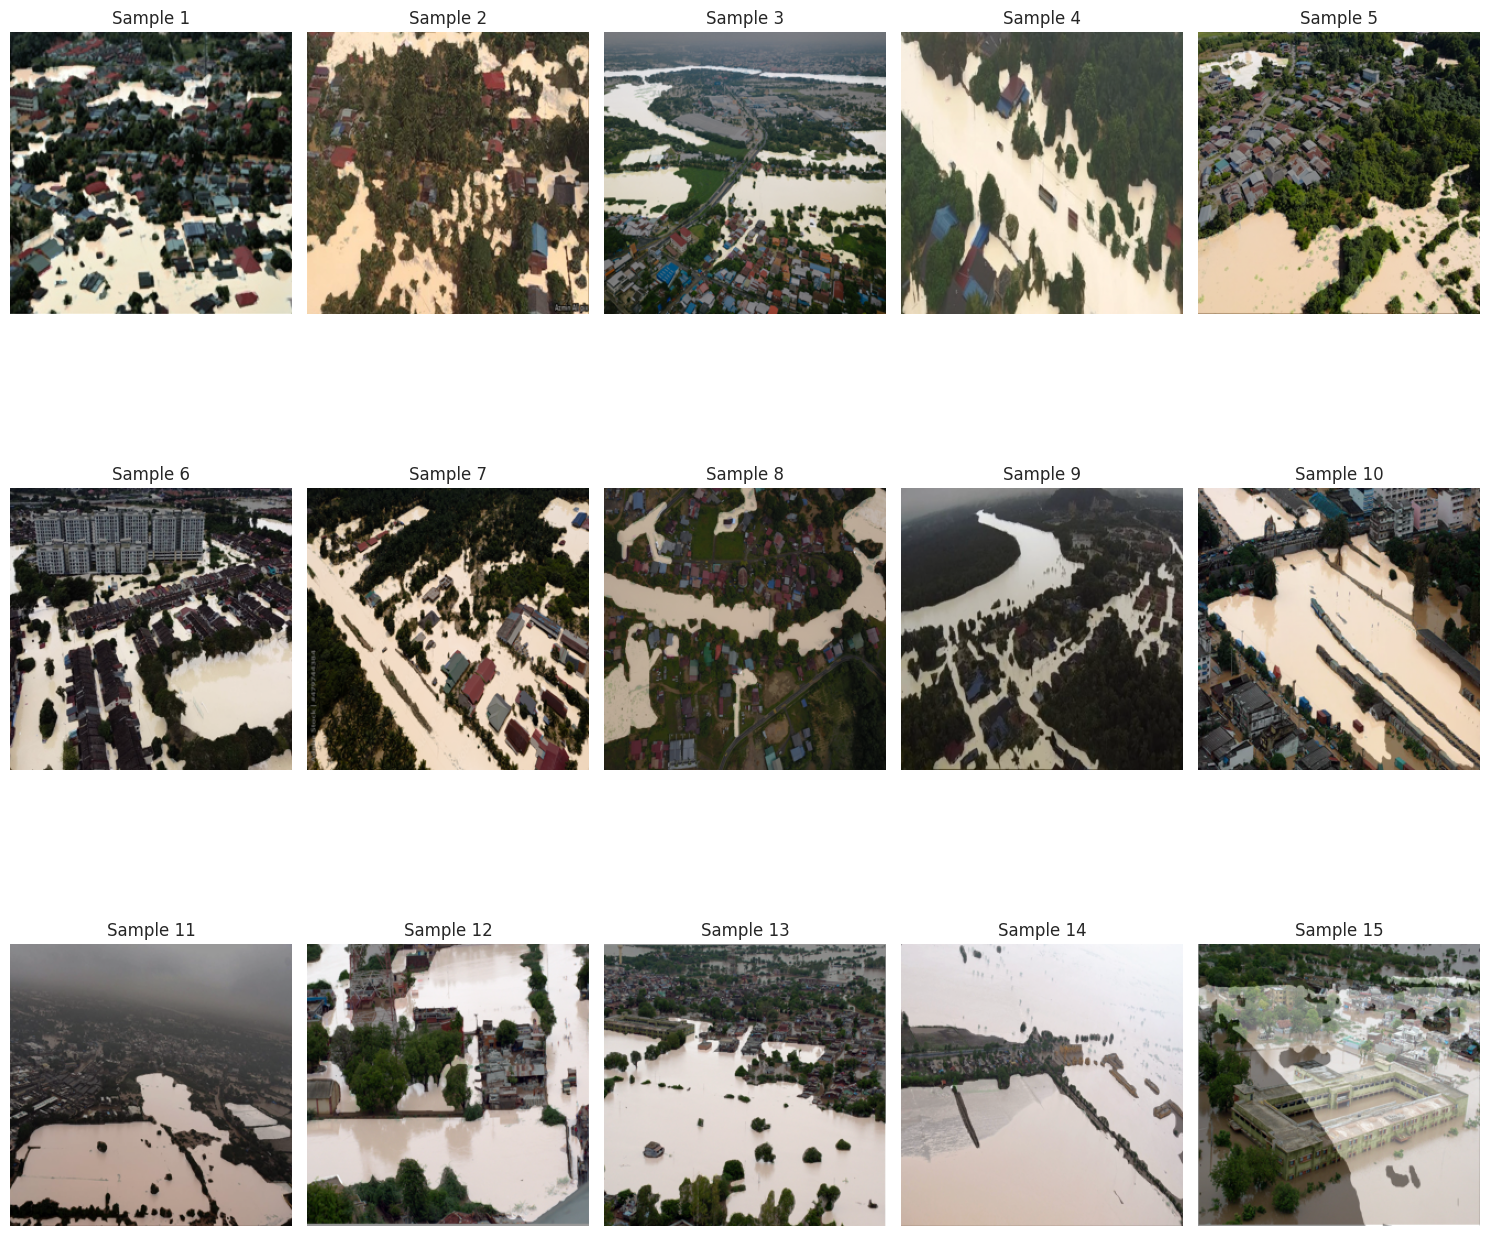

In [20]:
def create_data(data_directory, metadata_filename):
    """
    Generate lists of image and mask paths from metadata.csv.
    """
    # Load metadata CSV
    metadata_path = os.path.join(data_directory, metadata_filename)
    metadata_df = pd.read_csv(metadata_path)

    # Append paths for images and masks
    metadata_df["image_path"] = metadata_df["Image"].map(lambda img: os.path.join(data_directory, "Image", img))
    metadata_df["mask_path"] = metadata_df["Mask"].map(lambda msk: os.path.join(data_directory, "Mask", msk))

    # Return lists of paths
    return list(metadata_df["image_path"]), list(metadata_df["mask_path"])


def load_image(file_path, target_size):
    """
    Read and resize a single image or mask.
    """
    img = Image.open(file_path).convert("RGB")
    resized_img = img.resize((target_size, target_size))
    return np.array(resized_img) / 255.0  # Normalize


def load_images(file_paths, target_size, is_mask=False):
    """
    Batch-load images or masks from file paths.
    """
    results = []
    for file in file_paths:
        processed_img = load_image(file, target_size)
        if is_mask:  # Convert masks to single-channel
            processed_img = np.expand_dims(processed_img[:, :, 0], axis=-1)
        results.append(processed_img)

    return np.array(results)


def Show_images(images, masks, sample_count=15, grid_rows=3, grid_cols=5):
    """
    Display a grid of images with corresponding masks overlaid.
    """
    # Select the number of samples
    images, masks = images[:sample_count], masks[:sample_count]

    # Create grid for visualization
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 5 * grid_rows))

    for row in range(grid_rows):
        for col in range(grid_cols):
            idx = row * grid_cols + col
            if idx >= len(images):
                break

            axes[row, col].imshow(images[idx])  # Display the image
            axes[row, col].imshow(masks[idx].squeeze(), cmap="gray", alpha=0.4)  # Overlay the mask in gray
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Sample {idx + 1}")

    plt.tight_layout()
    plt.show()
# TODO: Load and visualize images
data_directory = "/kaggle/working/content/drive/MyDrive/Dataset"
metadata_filename = "metadata.csv"
image_size = 256
img_paths, msk_paths = create_data(data_directory, metadata_filename)
loaded_images = load_images(img_paths, image_size)
loaded_masks = load_images(msk_paths, image_size, is_mask=True)
Show_images(loaded_images, loaded_masks, sample_count=15, grid_rows=3, grid_cols=5)


## The Architecture
In addition to U-Net, we are going to utilize Attention Gates.
You probably need to read this paper: https://arxiv.org/pdf/1804.03999v3

In [22]:
# Dataset Preparation Class
class ImageMaskDataset(Dataset):
    def __init__(self, root_dir, limit=None, transform=None):
        self.root_dir = root_dir
        self.limit = limit
        self.image_paths = sorted([os.path.join(root_dir, "Image", img) for img in os.listdir(os.path.join(root_dir, "Image"))])[:limit]
        self.mask_paths = sorted([os.path.join(root_dir, "Mask", mask) for mask in os.listdir(os.path.join(root_dir, "Mask"))])[:limit]
        self.transform = transform or transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        return self.transform(image), self.transform(mask)

    def __len__(self):
        return len(self.image_paths)

# Custom Loss Functions
class DiceLoss(nn.Module):
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        dice_coeff = (2 * intersection + 1e-6) / (preds.sum() + targets.sum() + 1e-6)
        return 1 - dice_coeff

class JaccardLoss(nn.Module):
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum() - intersection
        jaccard_index = (intersection + 1e-6) / (union + 1e-6)
        return 1 - jaccard_index

# Encoder and Decoder Blocks
def create_conv_block(in_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            create_conv_block(in_channels, out_channels),
            create_conv_block(out_channels, out_channels)
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        features = self.conv(x)
        return features, self.pool(features)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            create_conv_block(in_channels, out_channels),
            create_conv_block(out_channels, out_channels)
        )

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat([x, skip_features], dim=1)
        return self.conv(x)

# UNet Model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        self.bottleneck = EncoderBlock(512, 1024)
        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1, pool1 = self.enc1(x)
        enc2, pool2 = self.enc2(pool1)
        enc3, pool3 = self.enc3(pool2)
        enc4, pool4 = self.enc4(pool3)
        bottleneck, _ = self.bottleneck(pool4)
        dec4 = self.dec4(bottleneck, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)
        return self.final_conv(dec1)

    def compute_loss(self, preds, targets):
        dice = DiceLoss()(preds, targets)
        jaccard = JaccardLoss()(preds, targets)
        return dice + jaccard

# Dataset Initialization and DataLoader
DATASET_DIR = "/kaggle/working/content/drive/MyDrive/Dataset"
transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
dataset = ImageMaskDataset(DATASET_DIR, limit=500, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False)


## Training

In [23]:
# Training Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)

        # Compute the loss
        loss = model.compute_loss(preds, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        pred_label = torch.sigmoid(preds) > 0.5
        correct = (pred_label == masks).float().sum()
        train_correct += correct
        train_total += masks.numel()

    train_loss /= len(train_loader)
    train_accuracy = (train_correct / train_total) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, masks in validation_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            loss = model.compute_loss(preds, masks)
            val_loss += loss.item()
            pred_label = torch.sigmoid(preds) > 0.5
            correct = (pred_label == masks).float().sum()
            val_correct += correct
            val_total += masks.numel()

    val_loss /= len(validation_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch {epoch + 1}/{EPOCHS}, "
        f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
    )


Epoch 1/100, Loss: 0.9109, Accuracy: 77.04%, Val Loss: 1.0139, Val Accuracy: 38.41%
Epoch 2/100, Loss: 0.7506, Accuracy: 81.19%, Val Loss: 0.7618, Val Accuracy: 76.17%
Epoch 3/100, Loss: 0.6898, Accuracy: 82.93%, Val Loss: 0.7387, Val Accuracy: 81.80%
Epoch 4/100, Loss: 0.6814, Accuracy: 82.37%, Val Loss: 0.6865, Val Accuracy: 79.57%
Epoch 5/100, Loss: 0.6849, Accuracy: 81.60%, Val Loss: 0.7342, Val Accuracy: 81.58%
Epoch 6/100, Loss: 0.6427, Accuracy: 82.94%, Val Loss: 0.6526, Val Accuracy: 81.90%
Epoch 7/100, Loss: 0.6152, Accuracy: 83.76%, Val Loss: 0.6573, Val Accuracy: 82.34%
Epoch 8/100, Loss: 0.5924, Accuracy: 84.23%, Val Loss: 0.6079, Val Accuracy: 81.66%
Epoch 9/100, Loss: 0.5700, Accuracy: 84.67%, Val Loss: 0.5941, Val Accuracy: 82.26%
Epoch 10/100, Loss: 0.5604, Accuracy: 84.63%, Val Loss: 0.7295, Val Accuracy: 69.66%
Epoch 11/100, Loss: 0.5661, Accuracy: 84.22%, Val Loss: 0.5860, Val Accuracy: 82.65%
Epoch 12/100, Loss: 0.5320, Accuracy: 85.14%, Val Loss: 0.5716, Val Accura

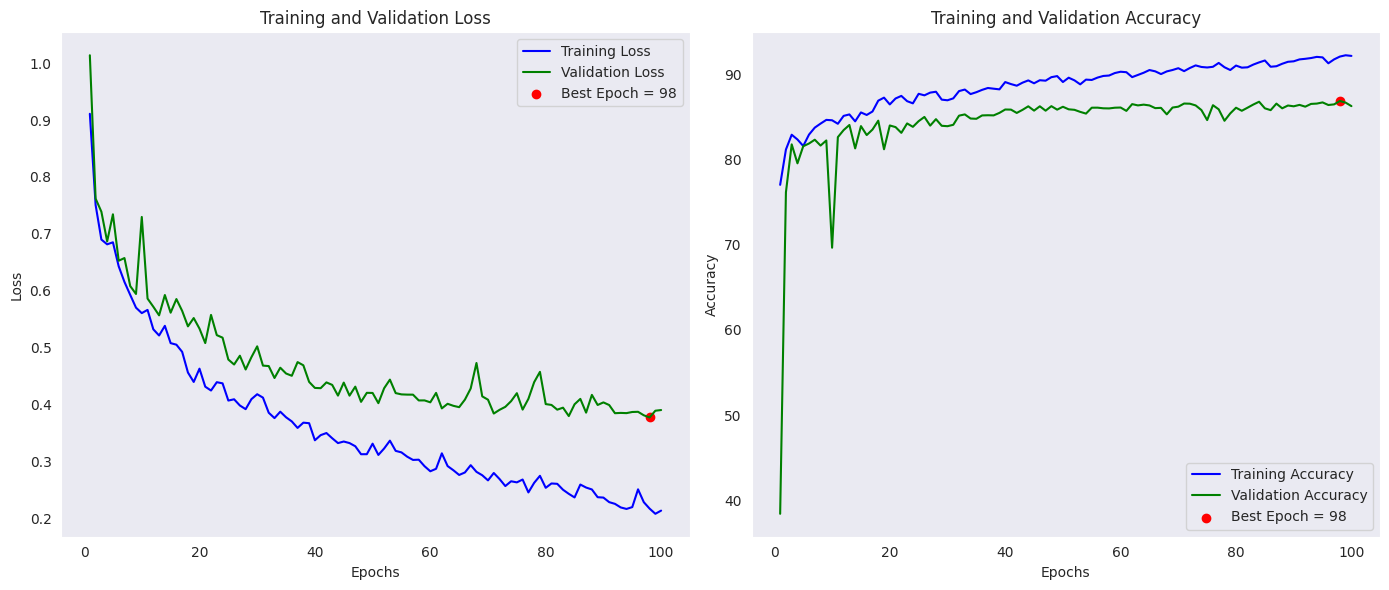

In [24]:
train_losses_np = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_np = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]
train_accuracies_np = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
val_accuracies_np = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracies]

epochs_list = list(range(1, EPOCHS + 1))

best_val_loss_idx = np.argmin(val_losses_np)
best_val_loss_epoch = best_val_loss_idx + 1
best_val_loss = val_losses_np[best_val_loss_idx]

best_val_accuracy_idx = np.argmax(val_accuracies_np)
best_val_accuracy_epoch = best_val_accuracy_idx + 1
best_val_accuracy = val_accuracies_np[best_val_accuracy_idx]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses_np, label='Training Loss', color='blue')
plt.plot(epochs_list, val_losses_np, label='Validation Loss', color='green')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Epoch = {best_val_loss_epoch}')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 20)))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies_np, label='Training Accuracy', color='blue')
plt.plot(epochs_list, val_accuracies_np, label='Validation Accuracy', color='green')
plt.scatter(best_val_accuracy_epoch, best_val_accuracy, color='red', label=f'Best Epoch = {best_val_accuracy_epoch}')
plt.xticks(ticks=list(range(0, EPOCHS + 1, 20)))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## Plottings

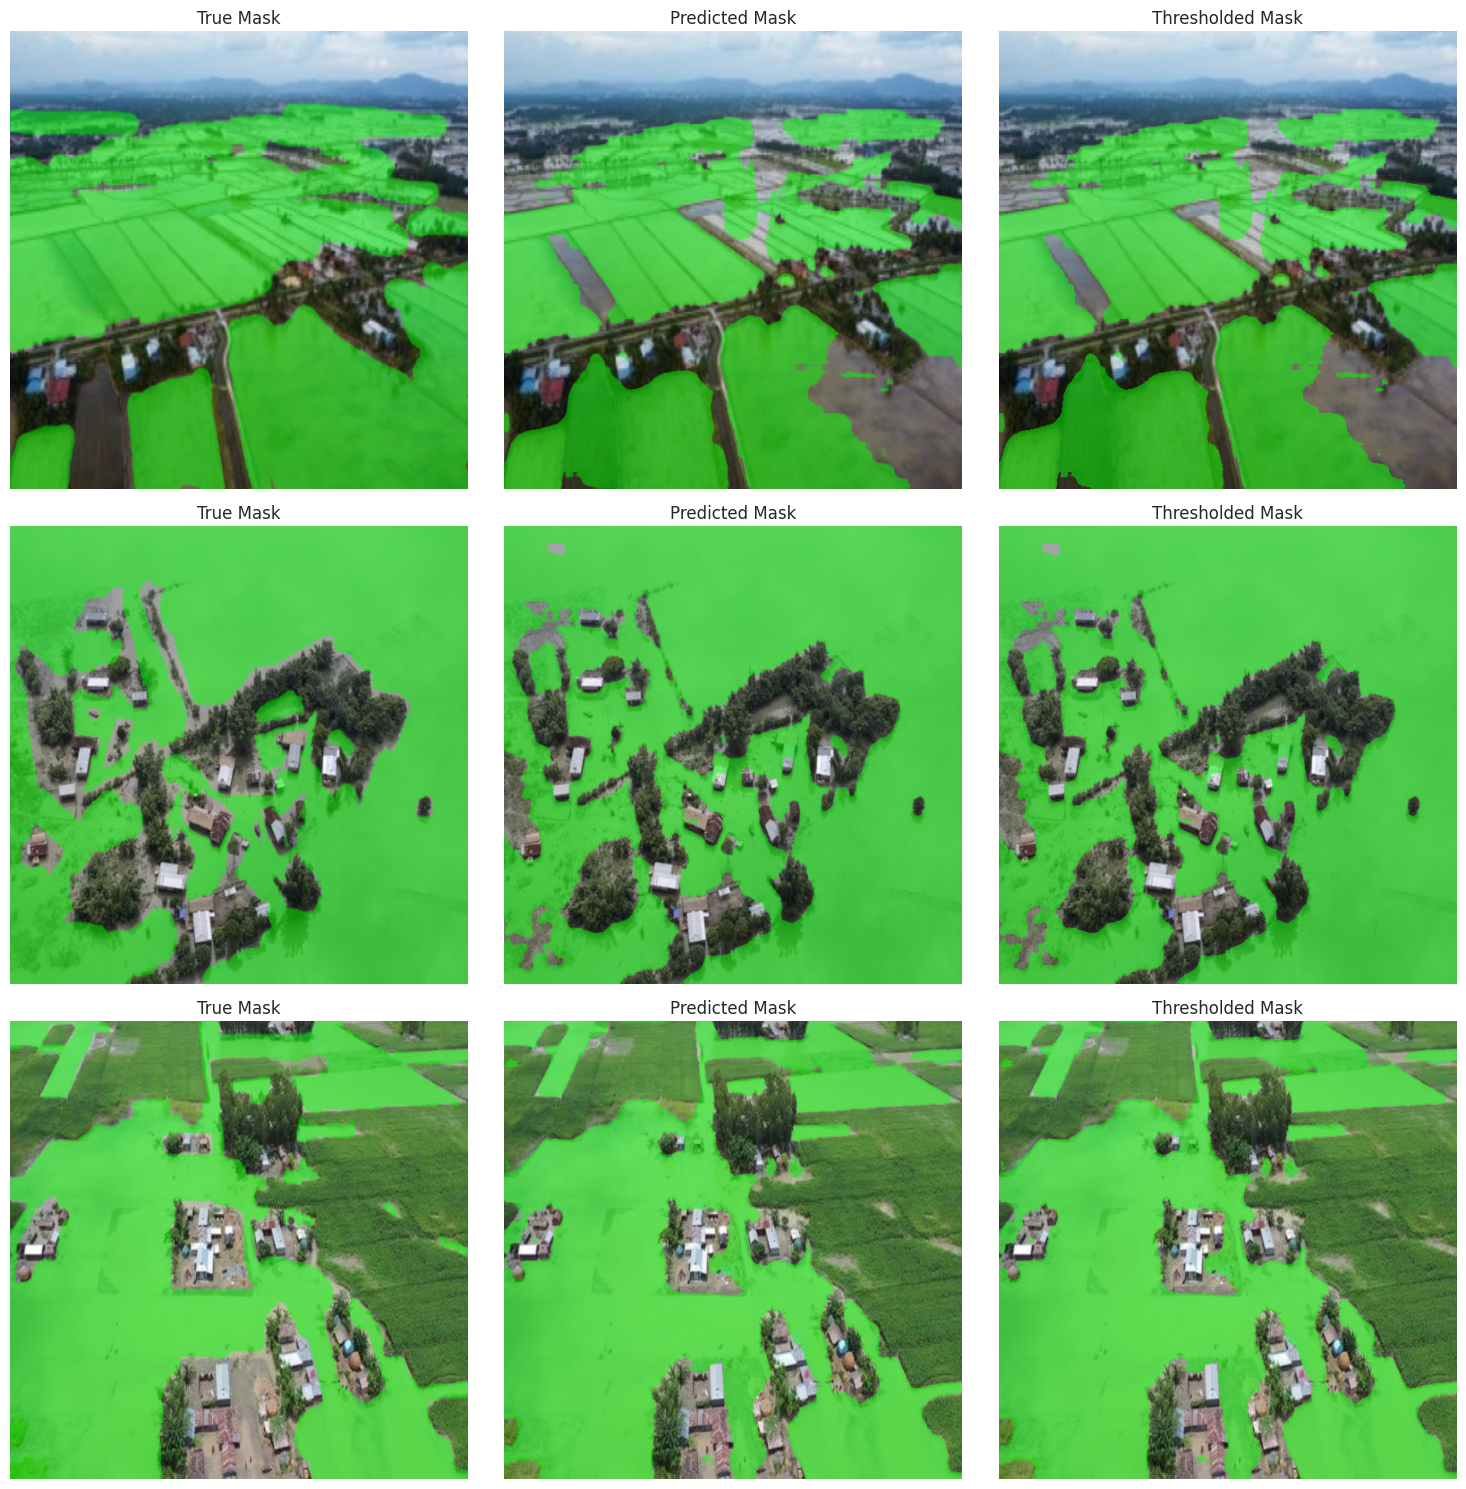

In [26]:
def overlay_mask(image, mask, alpha=0.5, color=(0, 1, 0)):
    overlay = image.copy()
    mask = mask.squeeze()  # Ensure mask has no extra dimensions
    for c in range(3):
        overlay[..., c] = overlay[..., c] * (1 - alpha * mask) + alpha * mask * color[c]
    return overlay

def plot_comparison(images, masks, predictions, threshold=0.5, num_samples=3):
    predictions = torch.sigmoid(predictions)  # Convert to probabilities
    thresholded_preds = (predictions > threshold).float()  # Apply threshold

    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (N, H, W, C)
    masks = masks.cpu().numpy()  # Convert masks to numpy
    predictions = predictions.cpu().detach().numpy()  # Convert predictions to numpy
    thresholded_preds = thresholded_preds.cpu().numpy()  # Convert thresholded masks to numpy

    num_cols = 3  # Columns: True Mask, Predicted Mask, Thresholded Mask
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Overlay true mask on image
        true_overlay = overlay_mask(images[i], masks[i])
        axes[i, 0].imshow(true_overlay)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("True Mask")

        # Overlay predicted mask on image
        pred_overlay = overlay_mask(images[i], predictions[i])
        axes[i, 1].imshow(pred_overlay)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Predicted Mask")

        # Overlay thresholded predicted mask on image
        thresh_overlay = overlay_mask(images[i], thresholded_preds[i])
        axes[i, 2].imshow(thresh_overlay)
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Thresholded Mask")

    plt.tight_layout()
    plt.show()

model.eval()
sample_images, sample_masks = next(iter(validation_loader))
sample_images, sample_masks = sample_images.to(device), sample_masks.to(device)
with torch.no_grad():
    sample_preds = model(sample_images)

plot_comparison(sample_images, sample_masks, sample_preds, threshold=0.5, num_samples=3)